In [1]:
# initializing the pca
import cv2 as cv

from skimage import io,measure,filters,morphology,transform
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

In [2]:
def return_exp(path):
    return [p.split('_')[0] for p in path.split('/') if 'LH' in p][0]

def return_well(path):
    return [p.split('_')[1] for p in path.split('/') if 'LH' in p][0]

def return_block(path):
    return [int(p.lower().split('block')[1]) for p in path.split('/') if 'block' in p.lower()][0]

def return_patient(exp,well):
    patient_dict = {
        'LH01_A01': '2020-015',
        'LH01_A02': '2020-015',
        'LH01_A03': '2020-017',
        'LH01_A04': '2020-069',
        'LH01_A05': '2020-069',
        'LH02_A03': '2020-015',
        'LH02_A04': '2020-015'
    }
    return patient_dict[exp+'_'+well]

In [3]:
# Load aggr info
path_to_aggr_archive = '/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Data/archive.txt'
aggr_archive = pd.read_csv(path_to_aggr_archive,header=None,names=['id','path','ROI-block-index','pixel_size'])
aggr_archive.head(5)

,id,path,ROI-block-index,pixel_size
0,0,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,0,4.230
1,1,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,1,4.230
2,2,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,2,3.136
3,3,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,3,3.136
4,4,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,4,3.136


In [4]:
# Load snapshot info
path_to_snapshot_archive = '/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/EM_snapshots/archive.txt'
snapshot_archive = pd.read_csv(path_to_snapshot_archive,header=None,names=['id','x-coordinate','y-coordinate','width','height','path','ROI-block-index'])
snapshot_archive.head(5)

,id,x-coordinate,y-coordinate,width,height,path,ROI-block-index
0,0,3466,5218,709,710,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,0
1,1,4594,4690,709,710,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,1
2,2,2834,3098,957,957,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,2
3,3,1942,2284,957,957,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,3
4,4,2182,3826,957,957,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,4


In [17]:
archive = snapshot_archive.merge(aggr_archive,left_on='path',right_on='path')[['id_x','x-coordinate','y-coordinate','width','height','path','ROI-block-index_x','pixel_size']]
archive['exp'] = archive.path.apply(return_exp)
archive['well'] = archive.path.apply(return_well)
archive['block'] = archive.path.apply(return_block)
archive['ROI-index'] = archive.groupby(['exp','well','block','ROI-block-index_x']).ngroup().astype(str)
archive['patient'] = archive.apply(lambda x: return_patient(x['exp'],x['well']),axis=1)
archive = archive.set_index('id_x')
archive['id'] = archive.index
archive

,x-coordinate,y-coordinate,width,height,path,ROI-block-index_x,pixel_size,exp,well,block,ROI-index,patient,id
id_x,,,,,,,,,,,,,
0,3466,5218,709,710,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,0,4.230,LH01,A01,1,0,2020-015,0
1,4594,4690,709,710,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,1,4.230,LH01,A01,1,1,2020-015,1
2,2834,3098,957,957,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,2,3.136,LH01,A01,1,2,2020-015,2
3,1942,2284,957,957,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,3,3.136,LH01,A01,1,3,2020-015,3
4,2182,3826,957,957,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,4,3.136,LH01,A01,1,4,2020-015,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,3610,3882,679,679,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,8,2.419,LH02,A03,2,33,2020-015,80
81,5348,10608,984,984,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,1,3.050,LH02,A04,1,41,2020-015,81
82,5754,6458,1240,1241,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,2,2.419,LH02,A04,1,42,2020-015,82


In [22]:
indeces_list = []
alphabet = ['A','B','C','D','E','F','G','H']
for ind in archive.index:
    num_before = (archive.loc[indeces_list,'ROI-index']==archive.loc[ind,'ROI-index']).sum()
    indeces_list.append(ind)
    num_after =  (archive.loc[archive.index.difference(indeces_list),'ROI-index']==archive.loc[ind,'ROI-index']).sum()
    if not(num_before==0 and num_after==0):
        archive.loc[ind,'ROI-id'] = archive.loc[ind,'ROI-index'] + alphabet[num_before]
    else: 
        archive.loc[ind,'ROI-id'] = archive.loc[ind,'ROI-index']
archive.to_csv('/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/EM_snapshots/archive-ROI-ids.txt')

In [23]:
# Load images
path = '/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/EM_snapshots'
out_path = '/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/EM_snapshots_edges'
img_shape = 1024
files = os.listdir(path)
img_dict = {}

for id in archive.index:
    fname = f"img{id}.tif"
    img_dict[id] = np.array(transform.resize(io.imread(os.path.join(path,fname)),(img_shape,img_shape)), dtype=np.float32)

# for f in files:
#     if "img" in f:
#         nr = int(f.split("img")[1].split(".tif")[0])
#         img_dict[nr] = np.array(transform.resize(io.imread(os.path.join(path,f)),(img_shape,img_shape)), dtype=np.float32)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

In [24]:
def right_hand_triangle_treshold(img,num_bins=256):
    # Right-hand triangle threshold
    # Right-hand triangle threshold
    H = cv.calcHist([img],[0],None,[num_bins],[img.min(),img.max()])
    H_centers = np.linspace(img.min(),img.max(),num_bins)
    m = 1 + np.argmax(H[1:]) # Omit first histogram entry because we don't want the max to be at 0
    linear_decline = np.linspace(H[m],H[-1],len(H)-m)
    d = np.sqrt((linear_decline - H[m:]) **2 / 2 ) # distances between histogram and linear decline
    return H_centers[m + np.argmax(d)]

In [25]:
# Helper function for calculating entropy
def entp(x):
    temp = np.multiply(x, np.log(x))
    temp[np.isnan(temp)] = 0
    return temp

def max_entropy_threshold(img,num_bins=256):
    # Maximum entropy
    H = cv.calcHist([img],[0],None,[num_bins],[img.min(),img.max()])
    H_centers = np.linspace(img.min(),img.max(),num_bins)
    H = H / np.sum(H)

    theta = np.zeros(num_bins)
    Hf = np.zeros(num_bins)
    Hb = np.zeros(num_bins)

    for T in range(1,num_bins-1):
        Hf[T] = - np.sum( entp(H[:T-1] / np.sum(H[1:T-1])) )
        Hb[T] = - np.sum( entp(H[T:] / np.sum(H[T:])) )
        theta[T] = Hf[T] + Hb[T]

    theta_max = H_centers[np.argmax(theta)]
    return theta_max


In [26]:
density_array = []
ridge_array = []
img_nrs = [65,84]
min_size = 100
sigmas = [1,2,3,4]

for img_nr in img_nrs:
    img = img_dict[img_nr]
    img_norm = (img - img.mean()) / img.std()
    img_inv  = img_norm.max()-img_norm
    img_inv_gauss = filters.gaussian(img_inv,sigma=1.5)
    density = (img_inv_gauss > filters.threshold_otsu(img_inv_gauss)).sum() / (img_shape*img_shape)

    meij = filters.meijering(img_norm,sigmas=sigmas,black_ridges=True)
    thr = (meij > right_hand_triangle_treshold(meij))
    thr_clean = morphology.remove_small_objects(thr, min_size)

    density_array.append(density)
    ridge_array.append(thr_clean.sum() / (img_shape*img_shape))

    io.imsave(f'/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Figures/fig_aggregates/img{img_nr}_ridges.tif', thr_clean)
    io.imsave(f'/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Figures/fig_aggregates/img{img_nr}_denisty.tif', (img_inv_gauss > filters.threshold_otsu(img_inv_gauss)))

/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_53167/4119149512.py:21: UserWarning: /Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Figures/fig_aggregates/img65_ridges.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(f'/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Figures/fig_aggregates/img{img_nr}_ridges.tif', thr_clean)
/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_53167/4119149512.py:22: UserWarning: /Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Figures/fig_aggregates/img65_denisty.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(f'/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Figures/fig_aggregates/img{img_nr}_denisty.tif', (img_inv_gauss > filters.threshold_otsu(img_inv_gauss)))
/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_53167/4119149512.py:21: UserWar

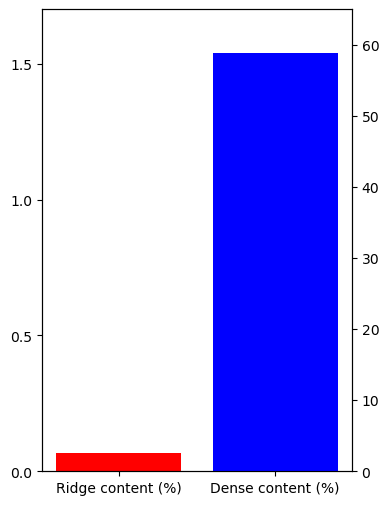

In [13]:
fig = plt.figure(figsize=(4,6)) # Create matplotlib figure

ax1 = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.
ax1.set_ylim([0,1.7])
ax2.set_ylim([0,65])

width = 0.4

ax1.bar(0,100*ridge_array[1],width=width, color='r')
ax2.bar(width+0.1,100*density_array[1],width=width,color='b')

ax1.set_xticks([0,0.5],labels=['Ridge content (%)','Dense content (%)'])
ax1.set_yticks([0,0.5,1,1.5])
fig.savefig('/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Figures/fig_aggregates/img84_barplot.png')


[51 75 25 10 22 57  5  5]


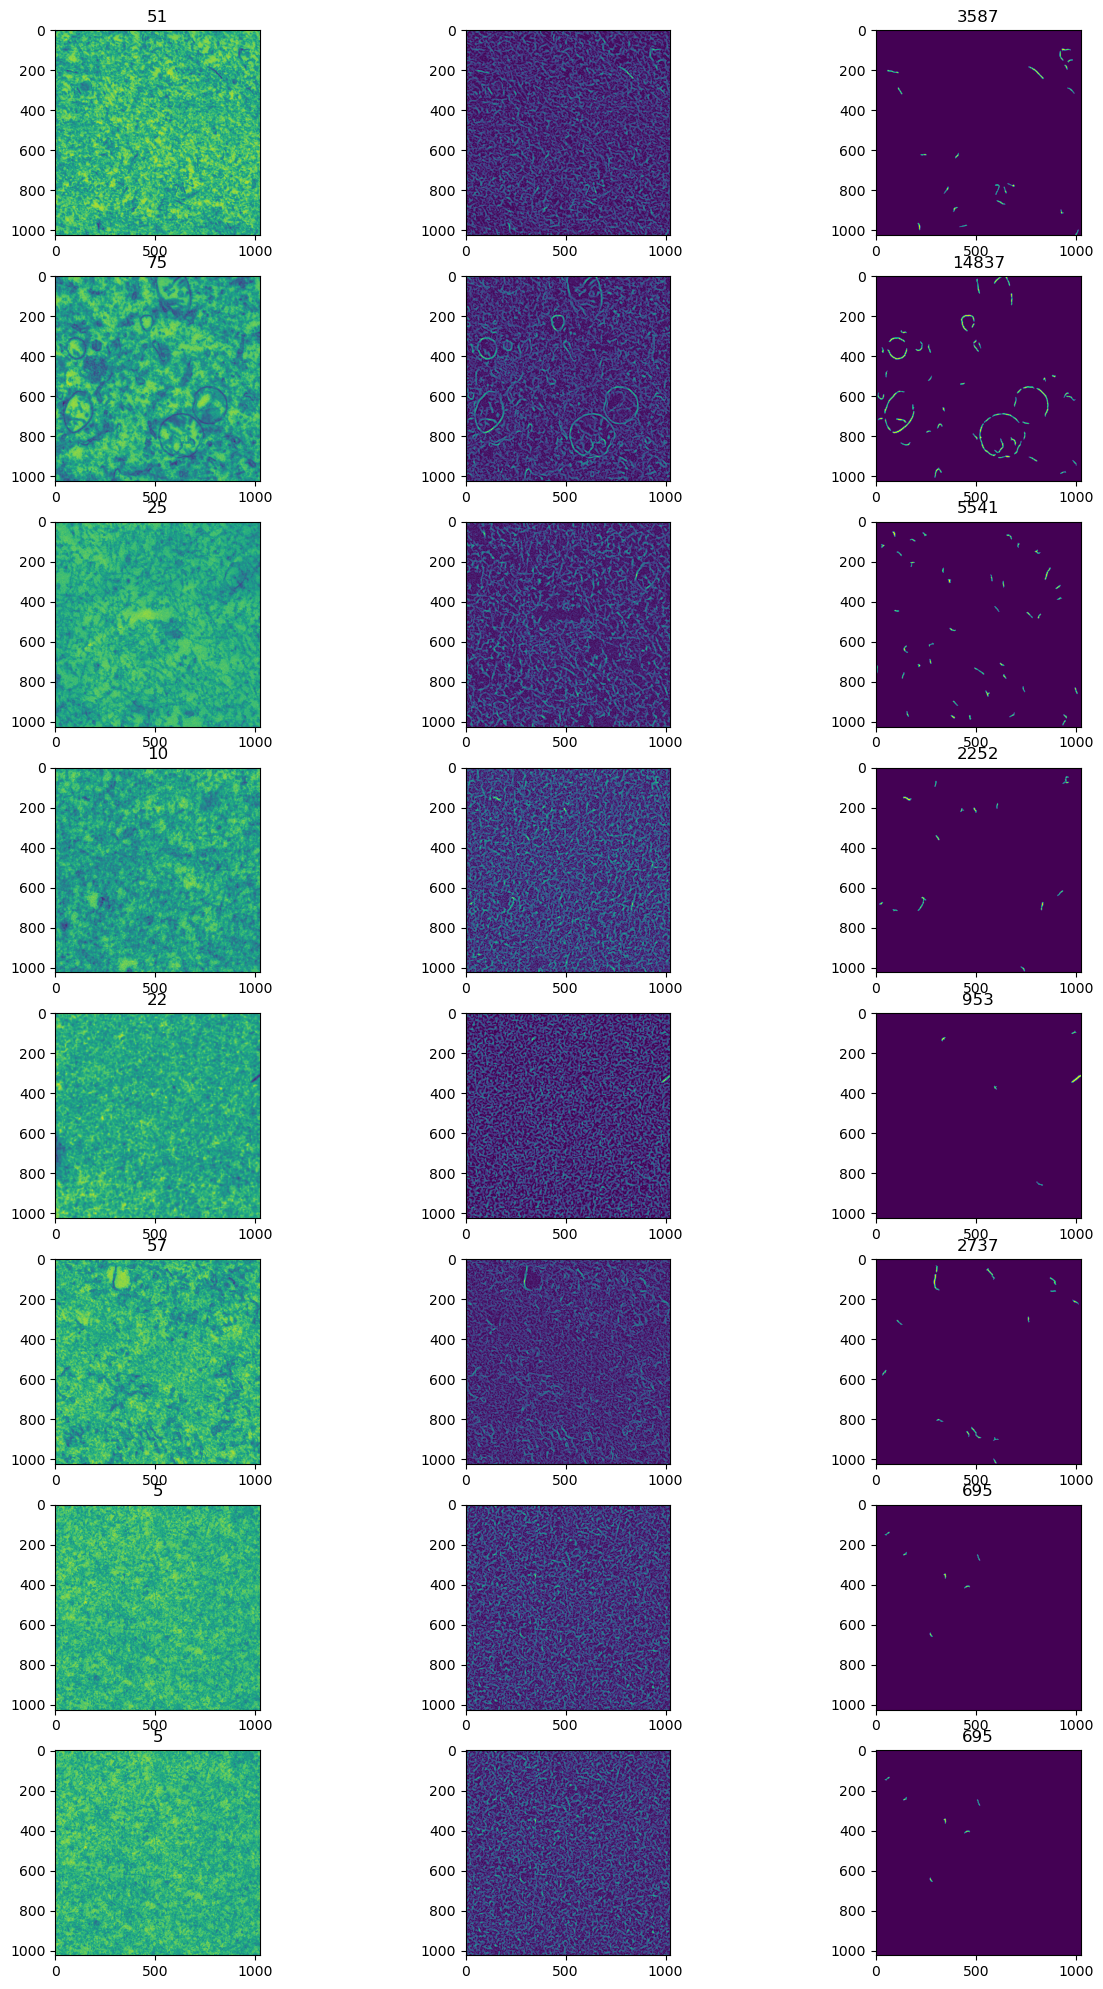

In [27]:
num_images = 8
min_size = 100
sigmas = [1,2,3,4]
black_ridges = True

fig,ax = plt.subplots(num_images,3,figsize=(15,25))
random_nrs = np.random.choice(list(img_dict.keys()),num_images)
random_nrs[0] = 51
print(random_nrs)

for i in range(num_images):
    nr = random_nrs[i]
    img = img_dict[nr]
    img_norm = (img - img.mean()) / img.std()
    meij = filters.meijering(img_norm,sigmas=sigmas,black_ridges=black_ridges)

    ax[i,0].imshow(img_norm)
    ax[i,0].set_title(nr)
    ax[i,1].imshow(meij)
    thr = (meij > right_hand_triangle_treshold(meij))
    thr_clean = morphology.remove_small_objects(thr, min_size=min_size)
    # labels = measure.label(thr_clean,connectivity=2)
    # ridge_sizes = np.array([(labels==l).sum() for l in np.arange(1,np.max(labels))])
    ax[i,2].imshow(thr_clean)
    ax[i,2].set_title(thr_clean.sum())


In [34]:
sigmas = [1,2,3,4]
black_ridges = True
min_size = 100

df = pd.DataFrame(index=img_dict.keys(),columns=['ridge_surface','dense_surface','aggregate_size_um2','nr'])
for nr,img in img_dict.items():
    roi_path = os.path.dirname(archive.loc[nr,'path'].strip())
    path_mask = os.path.join(roi_path,'hmEM_mask.tif')
    pixel_size = archive.loc[nr,'pixel_size']
    mask = io.imread(path_mask)==255

    img_norm = (img - img.mean()) / img.std()
    img_inv  = img_norm.max()-img_norm
    img_inv_gauss = filters.gaussian(img_inv,sigma=1.5)
    density = (img_inv_gauss > filters.threshold_otsu(img_inv_gauss)).sum() / (img_shape*img_shape)

    meij = filters.meijering(img_norm,sigmas=sigmas,black_ridges=black_ridges)
    thr = (meij > right_hand_triangle_treshold(meij))
    thr_clean = morphology.remove_small_objects(thr, min_size)
    
    df.loc[nr,'ridge_surface']      = thr_clean.sum() / (img_shape*img_shape) # scale #(ridge_sizes>large_ridge_size).sum() / len(ridge_sizes)
    df.loc[nr,'dense_surface']      = density
    df.loc[nr,'aggregate_size_um2'] = mask.sum() * pixel_size**2 / 1e6
    df.loc[nr,'nr']                 = nr

# Set dense surface of image 72 artifically, since Otsu thresholding doesn't work for this image
df.loc[72,'dense_surface'] = 0.87312 # Measured in Fiji

In [35]:
# Plotting preparation
fig_width = 600
fig_height = 500
plot_unique_aggregates_only = False
msize_range = [5,30]
df['ridge_surface_perc'] = df['ridge_surface'] * 100
df['dense_surface_perc'] = df['dense_surface'] * 100
df['aggregate_size_um2'] = df['aggregate_size_um2'].astype(float)

to_plot = df[['ridge_surface_perc','dense_surface_perc','aggregate_size_um2','nr']].merge(archive[['exp','well','patient','ROI-index','ROI-id']],left_index=True,right_index=True)
unique_ids = [0,2,3,4,5,6,7,8,10,14,15,16,18,23,24,27,31,33,34,35,36,39,40,43,49,51,54,55,56,57,59,60,61,63,65,67,74,75,76,77,81,83,84]
if plot_unique_aggregates_only:
    to_plot = to_plot.loc[unique_ids]

In [36]:
# Plot main figure
fig = go.Figure()
resized_size = (msize_range[0] + (msize_range[1]-msize_range[0]) * (to_plot['aggregate_size_um2'] - to_plot['aggregate_size_um2'].min()) / (to_plot['aggregate_size_um2'].max() - to_plot['aggregate_size_um2'].min())).astype(float)

fig.add_trace(go.Scatter(
    x=to_plot['dense_surface_perc'],
    y=to_plot['ridge_surface_perc'],
    mode='markers',
    marker=dict(
        size=resized_size,
        color='blue',
        opacity=0.6
    ),
    text=to_plot['nr']
))

fig.update_layout({
    'plot_bgcolor': 'rgba(255,255,255,1)',
    'paper_bgcolor': 'rgba(255,255,255,1)',
    'xaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 10,
        showline=True,
        linewidth = 1,
        linecolor='black'
    ),
    'yaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1,
        showline=True,
        linewidth = 1,
        linecolor='black'
    )
})
fig.update_layout(
    width=fig_width,
    height=fig_height,
    showlegend=False
)

#fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
#fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()
fig.write_image("/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Figures/fig_aggregates/scatterplot_main.pdf")

In [53]:
# Plot main figure with numbers
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=to_plot['dense_surface_perc'],
    y=to_plot['ridge_surface_perc'],
    mode='markers+text',
    marker=dict(
        size=resized_size,
        color='blue',
        opacity=0.1
    ),
    text=to_plot['ROI-id'],
    textposition="middle center",
))

fig.update_layout({
    'plot_bgcolor': 'rgba(255,255,255,1)',
    'paper_bgcolor': 'rgba(255,255,255,1)',
    'xaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 10,
        showline=True,
        linewidth = 1,
        linecolor='black'
    ),
    'yaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1,
        showline=True,
        linewidth = 1,
        linecolor='black'
    )
})
fig.update_layout(
    width=fig_width,
    height=fig_height,
    showlegend=False,
    font=dict(
        size=9
    )
)

#fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
#fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()
fig.write_image("/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Figures/ext_fig_aggregates/scatterplot_main_numbers.pdf")

In [33]:
# Plot colored by patient

fig = px.scatter(to_plot,x='dense_surface_perc',y='ridge_surface_perc',
                 size='aggregate_size_um2',
                 color='patient',
                 color_discrete_sequence=["orange","#556B2F"],
                 opacity=0.8,
                 hover_data='nr',
                 labels=dict(dense_surface_perc="Dense surface (%)", ridge_surface_perc="Ridge surface (%)")
)

fig.update_layout({
    'plot_bgcolor': 'rgba(255,255,255,1)',
    'paper_bgcolor': 'rgba(255,255,255,1)',
    'xaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 10,
        showline=True,
        linewidth = 1,
        linecolor='black'
    ),
    'yaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1,
        showline=True,
        linewidth = 1,
        linecolor='black'
    )
})
fig.update_layout(
    width=fig_width,
    height=fig_height,
    showlegend=False
)

#fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
#fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()
fig.write_image("/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Figures/fig_aggregates/scatterplot_c_per_patient.pdf")

In [204]:
# Plot colored by experimental method

fig = px.scatter(to_plot,x='dense_surface_perc',y='ridge_surface_perc',
                 size='aggregate_size_um2',
                 color='exp',
                 color_discrete_sequence=["orange","#556B2F"],
                 opacity=0.8,
                 hover_data='nr',
                 labels=dict(dense_surface_perc="Dense surface (%)", ridge_surface_perc="Ridge surface (%)")
)

fig.update_layout({
    'plot_bgcolor': 'rgba(255,255,255,1)',
    'paper_bgcolor': 'rgba(255,255,255,1)',
    'xaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 10,
        showline=True,
        linewidth = 1,
        linecolor='black'
    ),
    'yaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1,
        showline=True,
        linewidth = 1,
        linecolor='black'
    )
})
fig.update_layout(
    width=fig_width,
    height=fig_height,
    showlegend=False
)

#fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
#fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()
fig.write_image("/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Figures/fig_aggregates/scatterplot_c_per_method.pdf")

In [194]:
# Plot connections in z height

fig = go.Figure()

for roi_id in to_plot['ROI-index'].unique():
    sub_df = to_plot[to_plot['ROI-index']==roi_id]
    if len(sub_df)<=1:
        continue
    alpha = np.random.uniform(0.2,0.7)
    width = np.random.uniform(0.3,0.7)
    for i in range(len(sub_df)-1):
        x = [sub_df.iloc[i]['dense_surface_perc'],sub_df.iloc[i+1]['dense_surface_perc']]
        y = [sub_df.iloc[i]['ridge_surface_perc'],sub_df.iloc[i+1]['ridge_surface_perc']]
        fig.add_trace(go.Scatter(x=x,y=y,mode='lines',
                                 opacity=alpha,
                                 line=dict(
                                    color='blue',
                                    width=width,
                                    dash='dot'
                )
            )
        )

fig.add_trace(go.Scatter(
    x=to_plot['dense_surface_perc'],
    y=to_plot['ridge_surface_perc'],
    mode='markers',
    marker=dict(
        size=to_plot['aggregate_size_um2'],
        color='blue',
        opacity=0.6
    ),
    text=to_plot['nr']
))

fig.update_layout({
    'plot_bgcolor': 'rgba(255,255,255,1)',
    'paper_bgcolor': 'rgba(255,255,255,1)',
    'xaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 10,
        showline=True,
        linewidth = 1,
        linecolor='black'
    ),
    'yaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1,
        showline=True,
        linewidth = 1,
        linecolor='black'
    )
})
fig.update_layout(
    width=fig_width,
    height=fig_height,
    showlegend=False
)

#fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
#fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()
fig.write_image("/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Figures/fig_aggregates/scatterplot_z_connections.pdf")